---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

# Bike Sharing Demand: Forecast use of a city bikeshare system

## Data Description
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
[Kaggle dataset](https://www.kaggle.com/c/bike-sharing-demand/data)

## Data Fields
* datetime - hourly date + timestamp
* season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather -
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('default')
%matplotlib inline  

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Import the Data
In this project, we only work with the file _train.csv_ because there is no need to participate in this competition.

In [2]:
train = pd.read_csv('train.csv', parse_dates = ['datetime']).sort_values(by=['datetime'])

## Data Summary

In [3]:
train.shape

(10886, 12)

In [4]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


## Check the Normality of Target Variable

In [7]:
def normality_ecdf_checking(data, axes, xlabel = None):
    """Overlay the ecdf plots of real data and theoretical data following a normal distribution 
    with the same mean and standard deviation with real data"""
    n = len(data)
    
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    axes.plot(x, y, marker = '.', linestyle = 'none')
    
    normal_data = np.random.normal(data.mean(), data.std(), n)
    x_normal = np.sort(normal_data)
    axes.plot(x_normal, y, marker = '.', linestyle = 'none')
    
    axes.set_xlabel(xlabel)
    axes.set_ylabel('ecdf')

### Original Data

The 'count' variable is right-skewed and does not follow the normal distribution. 

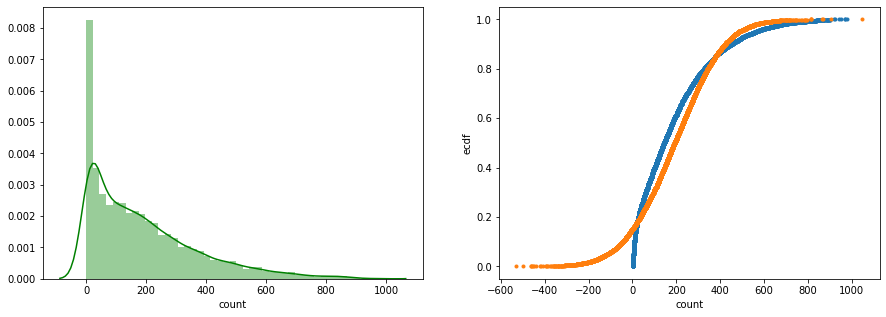

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
sns.distplot(train['count'], color = 'g', ax = ax[0])
normality_ecdf_checking(train['count'], ax[1], 'count')

### Log - Transformed Data

The 'count' variable after being log-transformed is no longer right-skewed but still does not follow normal distribution.

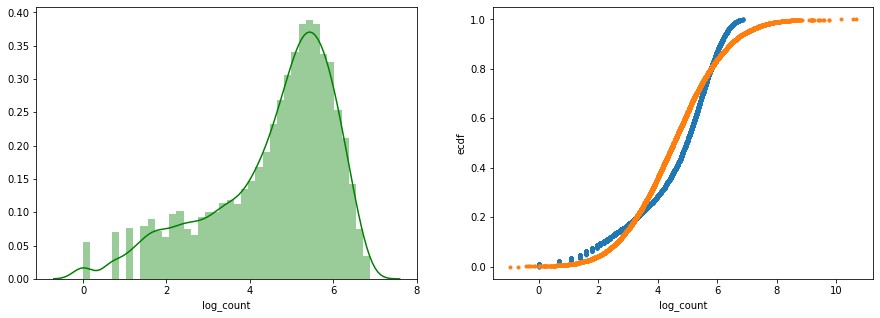

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
train['log_count'] = train['count'].apply(np.log)
sns.distplot(train['log_count'], color = 'g', ax = ax[0])
normality_ecdf_checking(train['log_count'], ax[1], 'log_count')

## Explore Discrete Features

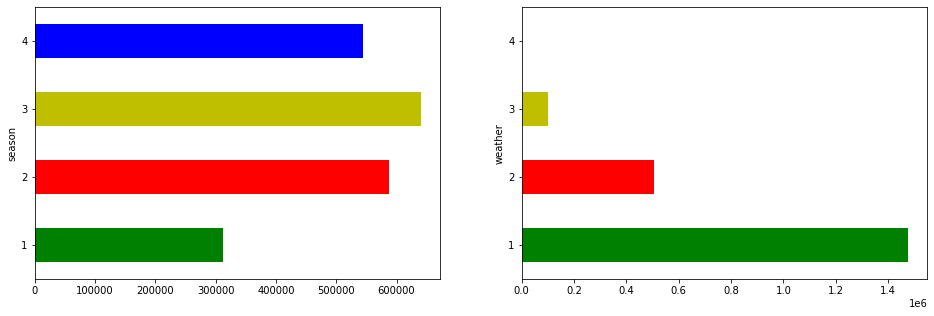

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 5)
train.groupby('season')['count'].sum().plot(kind = 'barh', ax = ax[0], color = ['g', 'r', 'y', 'b'])
train.groupby('weather')['count'].sum().plot(kind = 'barh', ax = ax[1], color = ['g', 'r', 'y', 'b'])

By season, the number of bikes rented is biggest in the fall, then the summer and winter, while the number of bikes rented in spring is less than half compared to the fall.<br>
By weather, the total count of bikes rented decreases according to the weather conditions.

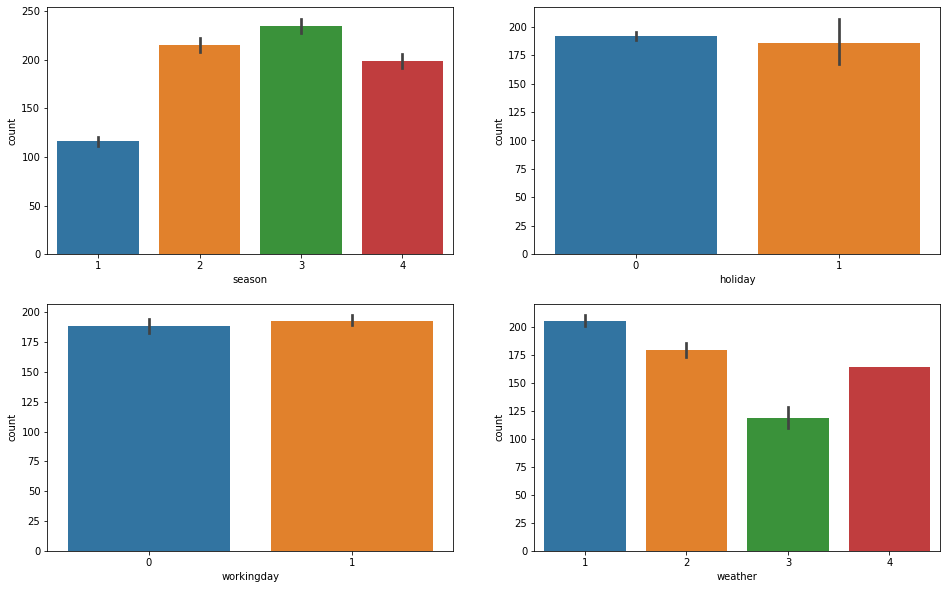

In [11]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16, 10)
sns.barplot(x = 'season', y = 'count', data = train, orient = 'v', ax = ax[0,0])
sns.barplot(x = 'holiday', y = 'count', data = train, orient = 'v', ax = ax[0,1])
sns.barplot(x = 'workingday', y = 'count', data = train, orient = 'v', ax = ax[1,0])
sns.barplot(x = 'weather', y = 'count', data = train, orient = 'v', ax = ax[1,1])

There is almost no difference of the average number of bikes rented between holiday and non-holiday, working day and non-working day.

In [12]:
train[train['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,log_count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,5.099866


Note that there is only one right time when bikes were rented in weather conditions 4, which can be a rush hour and the weather is suddenly bad.

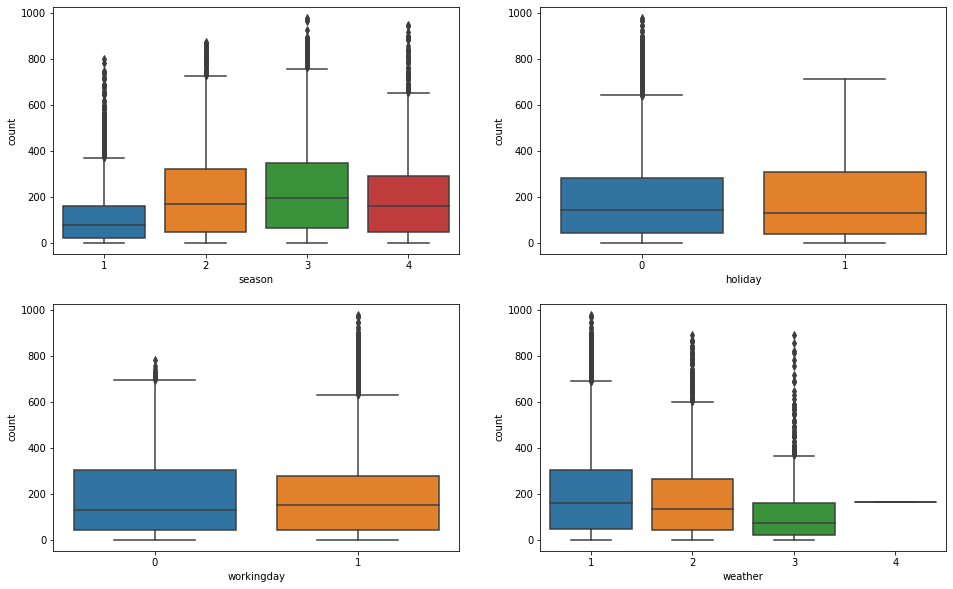

In [13]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16, 10)
sns.boxplot(x = 'season', y = 'count', data = train, orient = 'v', ax = ax[0,0])
sns.boxplot(x = 'holiday', y = 'count', data = train, orient = 'v', ax = ax[0,1])
sns.boxplot(x = 'workingday', y = 'count', data = train, orient = 'v', ax = ax[1,0])
sns.boxplot(x = 'weather', y = 'count', data = train, orient = 'v', ax = ax[1,1])

Most of the outlier points mainly come from working day, and non-holiday.<br>
There is no unusual difference between the order of the means and the medians respectively.

## Explore Continous Features

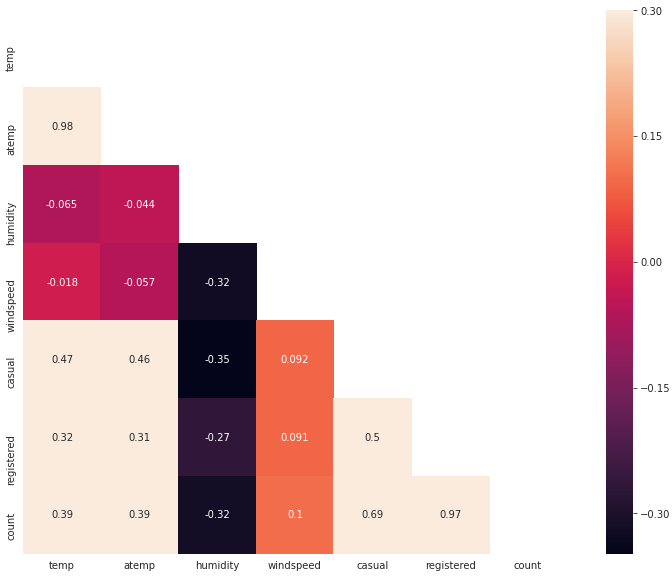

In [14]:
corr = train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

'casual' and 'registered' are leakage variables in nature and need to dropped during model building, they have strong correlation with 'count'.<br>
'temp' and 'atemp' are highly related. We need to drop one of two features during model building.

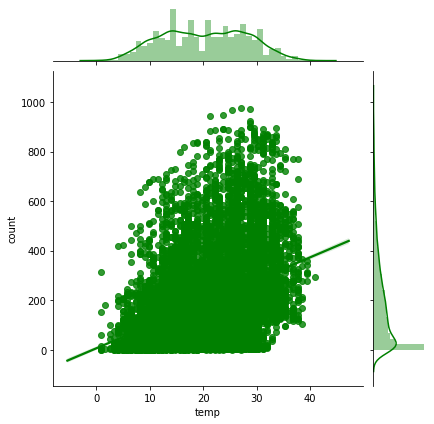

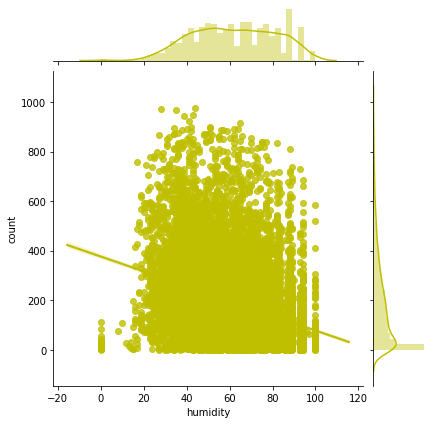

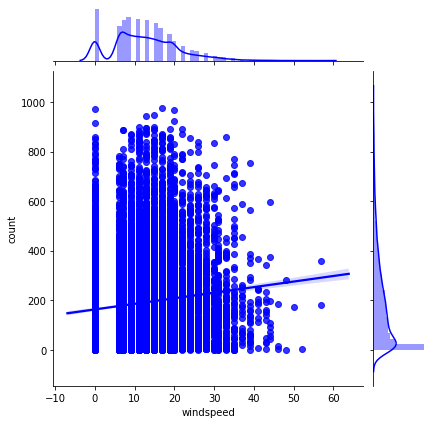

In [15]:
# fig,(ax1, ax2, ax3)= plt.subplots(ncols = 3)
# fig.set_size_inches(18,5)
sns.jointplot(data = train, x = 'temp', y = 'count', kind = 'reg', color = 'g')
sns.jointplot(data = train, x = 'humidity', y = 'count', kind = 'reg', color = 'y')
sns.jointplot(data = train, x = 'windspeed', y = 'count', kind = 'reg', color = 'b')

'windspeed' has got positive correlation with 'count', but extremely week, and this is a variable that doesn't have much significance in estimating.<br>
'temp' and 'humidity' features has got positive and negative correlation with 'count' respectively, but not much.

## Handling the Missing Values

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 13 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
log_count     10886 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 1.5 MB


,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


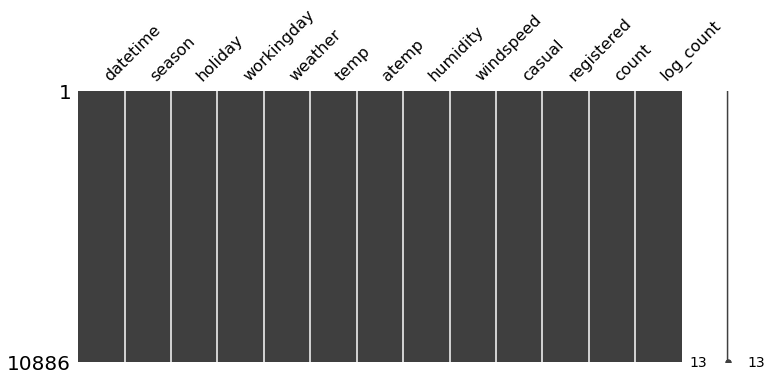

In [17]:
msno.matrix(train, figsize=(12,5))
train[['temp','atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].describe()

All the continous features have positive values.<br>
We also do not see any unusual value of variables: 'season', 'holiday', 'workingday', and 'weather' during exploring features.

In [18]:
# check duplicate datetimes
duplicates = train.duplicated(subset = ['datetime'], keep = False)
train[duplicates].sort_values(by = 'datetime')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,log_count


There is no duplicate datetimes values.

## Feature Engineering

In [19]:
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday
train['month'] = train['datetime'].dt.month

In [20]:
train['season'].replace({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}, inplace = True)
train['holiday'].replace({1: 'Yes', 0: 'No'}, inplace = True)
train['workingday'].replace({1: 'Yes', 0: 'No'}, inplace = True)
train['weather'].replace({1: 'Clear, Few clouds, Partly cloudy, Partly cloudy', 
                                             2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 
                                             3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
                                             4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}, inplace = True)
train['weekday'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}, inplace = True) 
train['month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                       7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}, inplace = True)

In [21]:
category_features = ['season', 'holiday', 'workingday', 'weather', 'month', 'weekday', 'hour']
train[category_features] = train[category_features].astype('category')

In [22]:
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekday_order = ['Sunday', 'Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

##  How Count Varies with Different Features

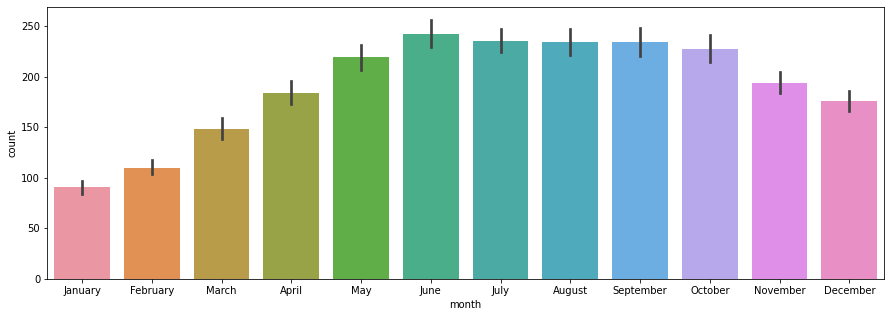

In [23]:
fig = plt.figure()
sns.barplot(data = train, x = 'month', y = 'count', order = month_order)
fig.set_size_inches(15,5)

We can use 'month' and drop 'season' during model building to avoid multicollinearity in the data and get more correct predictions.

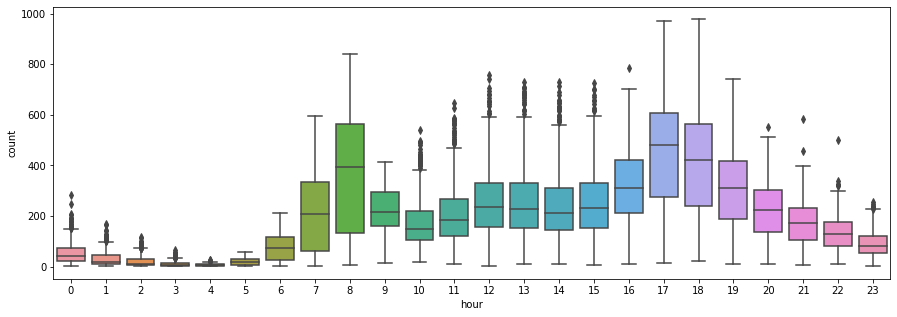

In [24]:
fig = plt.figure()
sns.boxplot(data = train, x = 'hour', y = 'count')
fig.set_size_inches(15,5)

The median value of count are relatively higher at 7am-8am and 5pm-6pm. One of the reasons is that in most cities this is the peak time and more people tend to rent bikes.

In [25]:
casual_and_registered = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])

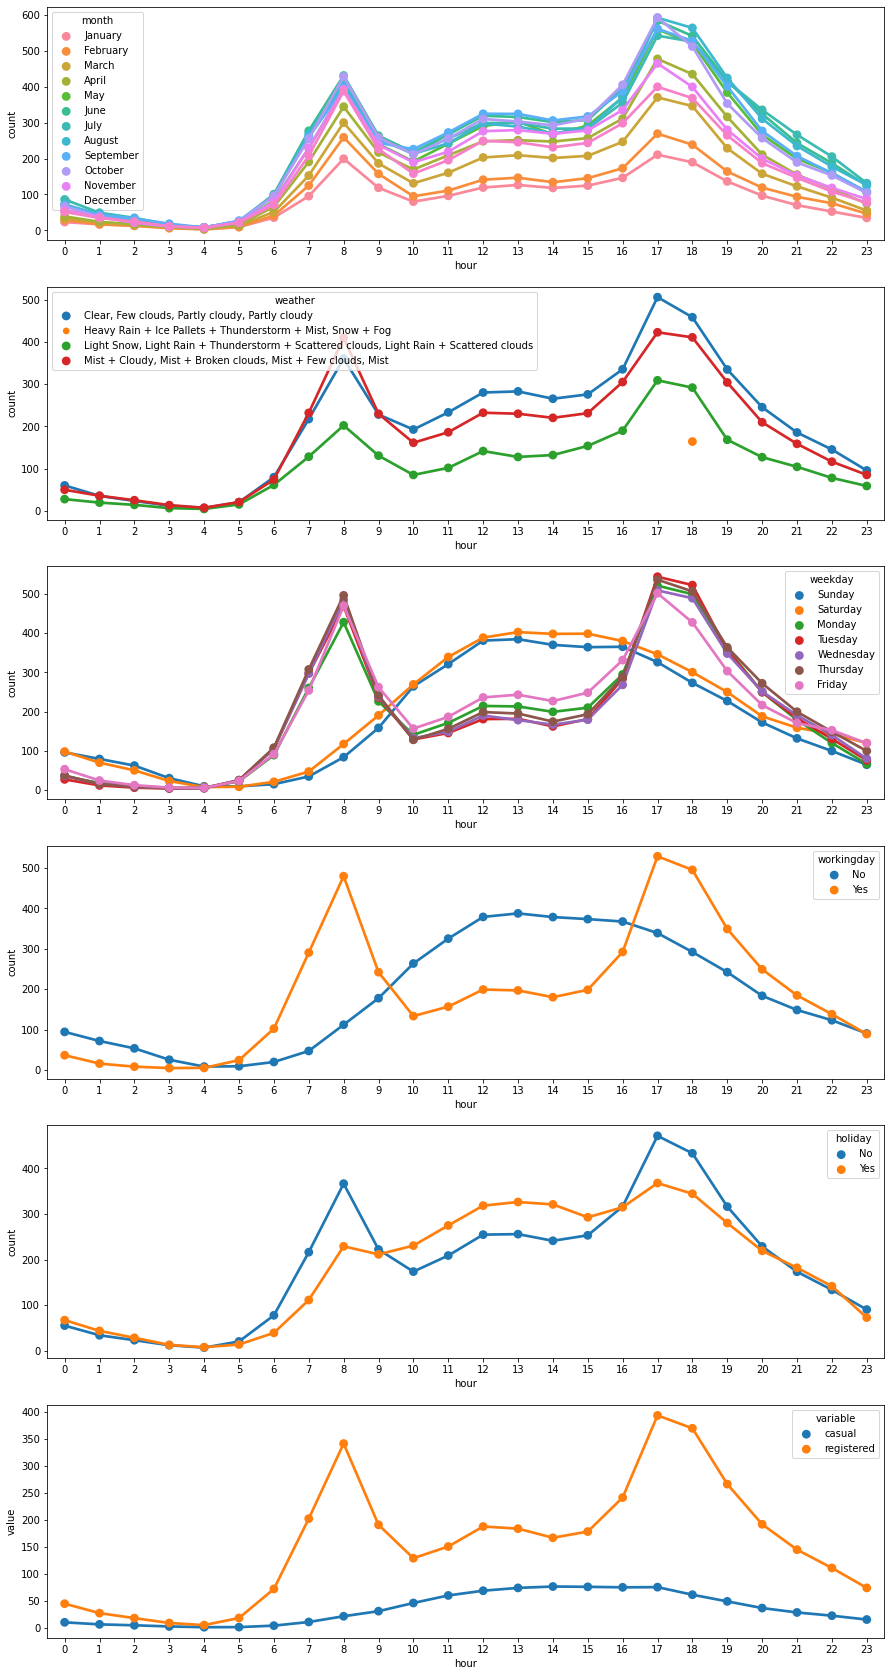

In [26]:
fig,(ax1, ax2, ax3, ax4, ax5, ax6)= plt.subplots(nrows = 6)
fig.set_size_inches(15,30)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'weather', ax = ax2, ci=None)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'month', ax = ax1, ci=None, hue_order = month_order)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'weekday', ax = ax3, ci=None, hue_order = weekday_order)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'workingday', ax = ax4, ci=None)
sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'holiday', ax = ax5, ci=None)
sns.pointplot(data = casual_and_registered, x = 'hour', y = 'value', hue = 'variable', ax = ax6, ci=None)

On Saturdays and Sundays, people tend to rent bicycles between 10am and 4pm instead of 7am-8am and 5pm-6pm like weekdays.<br>
The peak number of users between 7am-8am and 5pm-6pm is entirely contributed by registered users.

## Drop Unnecessary Features and Split Data

In [27]:
X = train.drop(['datetime', 'casual', 'registered', 'season', 'count', 'log_count', 'atemp'], axis=1)
y = train['count']

In [28]:
X = pd.get_dummies(X, drop_first = True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 12)

## RMSLE Function

In [30]:
def rmsle(y, y0, convertExp=True):
    if convertExp:
        y = np.exp(y),
        y0 = np.exp(y0)
    log1 = np.nan_to_num(np.log1p(y))
    log2 = np.nan_to_num(np.log1p(y0))
    return np.sqrt(np.mean(np.square(log1 - log2)))

## Machine Learning Model

### Linear Regression Model

In [31]:
lg = LinearRegression()

# Train the model
lg.fit(X_train, np.log(y_train))

# Make predictions
y_pred_log = lg.predict(X_test)
print ("RMSLE Value For Linear Regression: ", rmsle(y_test, np.exp(y_pred_log)))

RMSLE Value For Linear Regression:  inf


### Ridge Model

{'alpha': 0.36787944117144233, 'max_iter': 1000}
0.6311919302410687
RMSLE Value For Ridge Regression:  0.624603834696798


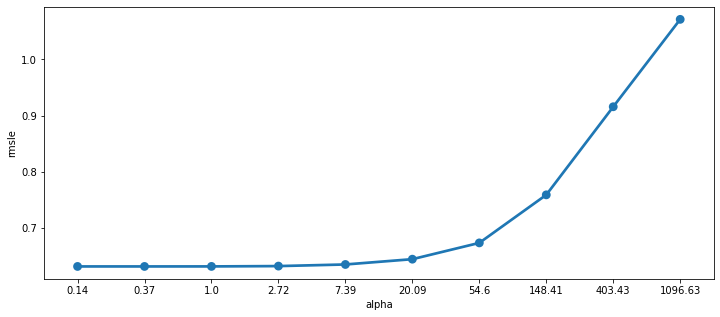

In [32]:
ridge = Ridge()
ridge_params_ = {'max_iter': [1000],'alpha': np.exp(range(-2,8))}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge = GridSearchCV( ridge,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
# yLabelsLog = np.log1p(y_train)
grid_ridge.fit(X_train, np.log(y_train))
y_pred_log = grid_ridge.predict(X_test)
print(grid_ridge.best_params_)
print(-grid_ridge.best_score_)
print("RMSLE Value For Ridge Regression: ", rmsle(y_test, np.exp(y_pred_log), False))

fig, ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge.cv_results_)
df['alpha'] = df['params'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)
sns.pointplot(x = round(df['alpha'], 2) ,y = df['rmsle'], ax=ax)

### Lasso Model

{'alpha': 0.1353352832366127, 'max_iter': 1000}
1.2434994842255536
RMSLE Value For Lasso Regression:  1.2278143893915183


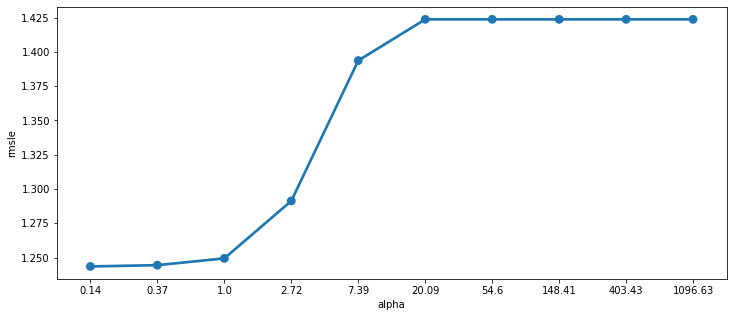

In [33]:
lasso = Lasso()
lasso_params_ = { 'max_iter':[1000],'alpha': np.exp(range(-2,8))}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_lasso = GridSearchCV( lasso,
                          lasso_params_,
                          scoring = rmsle_scorer,
                          cv=5)
# yLabelsLog = np.log1p(y_train)
grid_lasso.fit(X_train, np.log(y_train))
y_pred_log = grid_lasso.predict(X_test)
print(grid_lasso.best_params_)
print(-grid_lasso.best_score_)
print("RMSLE Value For Lasso Regression: ", rmsle(y_test, np.exp(y_pred_log), False))

fig, ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso.cv_results_)
df['alpha'] = df['params'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)
sns.pointplot(x = round(df['alpha'], 2) ,y = df['rmsle'], ax=ax)

### Random Forest Model

In [34]:
rf = RandomForestRegressor(n_estimators= 500)
rf.fit(X_train, np.log(y_train))
y_pred_log = rf.predict(X_test)
print ("RMSLE Value For Random Forest: ", rmsle(y_test, np.exp(y_pred_log), False))

RMSLE Value For Random Forest:  0.4557090665298596


In [35]:
# rfc= RandomForestRegressor(random_state = 12)
# rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring = rmsle_scorer, cv= 5, n_jobs = -1, verbose = 2)
# grid_rfc.fit(X_train, np.log(y_train))
# y_pred = grid_rfc.predict(X_test)
# print(grid_rfc.best_params_)
# print(-grid_rfc.best_score_)
# print("RMSLE Value For Random Forest Regression: ", rmsle(y_test, np.exp(y_pred), False))

### Gradient Boost Model

In [36]:
gbm = GradientBoostingRegressor(n_estimators = 4000, alpha = 0.01)
gbm.fit(X_train, np.log(y_train))
y_pred_log = gbm.predict(X_test)
print ("RMSLE Value For Gradient Boost: ", rmsle(y_test, np.exp(y_pred_log), False))

RMSLE Value For Gradient Boost:  0.401334374194591
